# Algoritmos de recuperação

Neste notebook jupyter iremos ter um primeiro contato com os algoritmos de recuperação de fase, mostrando os diversos tipos de algoritmos e aplicando para um caso "ideal".

Primeiro vamos importar todas as bibliotecas necessárias

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fftn, ifftn, fftshift, ifftshift
from skimage.transform import resize
from PIL import Image
import random

Agora vamos importar o objeto que queremos reconstruir, que no caso é a imagem da ema e normalizá-la para ter valores entre 0 e 1. Logo em seguida plotamos a imagem do objeto.

(<matplotlib.image.AxesImage at 0x7fe9edf74ed0>,
 <matplotlib.colorbar.Colorbar at 0x7fe9edd45710>)

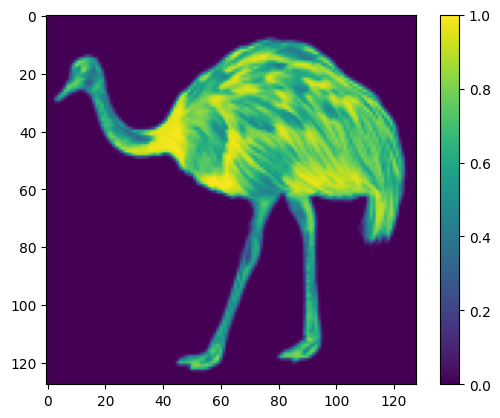

In [2]:
im = Image.open('ema2.jpg')
im = np.array(im).astype('float32')
im = 0.2989 * im[:,:,0] + 0.5870 * im[:,:,1] + 0.1140 * im[:,:,2]
im = -resize(im, [128,128])
im = (im - np.min(im))/np.ptp(im)
L = np.array(im.shape)
halfL = np.ceil(L/2)

plt.imshow(im), plt.colorbar()

Nesta etapa, vamo aplicar chamado "oversampling", que é uma condição necessária para que o algoritmo convirja, no sentido de que daremos informação suficiente no espaço recíproco. Novamente, plotamos a imagem do objeto logo em seguida.

Segue um vídeo que dá uma noção boa do que é esse "oversampling": https://www.youtube.com/watch?v=yWqrx08UeUs

(<matplotlib.image.AxesImage at 0x7fe9eddcd610>,
 <matplotlib.colorbar.Colorbar at 0x7fe9edda2550>)

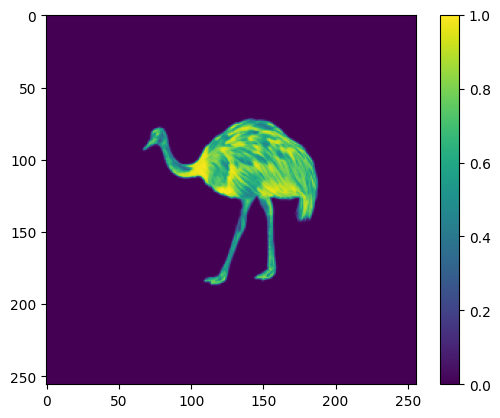

In [3]:
overSampling = 2
Ov = np.array([overSampling,overSampling]).astype(np.float32)
Ov = ((Ov-1)/2)*(np.shape(im))
Ov = np.int16(Ov)
im = np.pad(im, (Ov,Ov), 'constant', constant_values=(0,0)).astype(np.float32)

plt.imshow(im), plt.colorbar()

E então definimos a nossa região de suporte inicial, isto é, a região onde sabemos com certeza que nossa amostra está no espaço real. Esta região está em amarelo no plot abaixo, e todos seus pixels tem valor 1. Todos os pixels fora do suporte estão em roxo e tem valor 0.

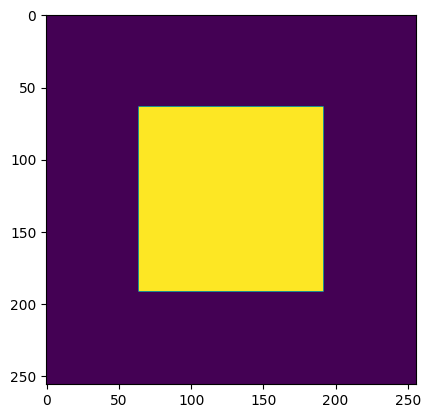

In [4]:
supp = np.zeros(np.shape(im), dtype = bool)
supp[64:192,64:192] = 1

plt.imshow(supp)

Agora definiremos o que seria nossa intensidade medida no detector, note que eu tomo a transformada de fourier e então sua intensidade, a fim de emular a nossa medida real. Logo em seguida plotamos a intensidade medida.

Observação: a função fftshift() tem a função reorganizar os quadrantes da transformada, a fim de colocar as contribuições de frequência 0 no centro da imagem. Isto vem devido ao jeito que a transformada rápida de fourier (FFT) é computada. Também aplicamos um logaritmo np.log10() para evidenciar todas as franjas da imagem.

Segue um vídeo bem interessante sobre a transformada rápida de Fourier (e sua enorme importância histórica na corrida armamentista): https://www.youtube.com/watch?v=nmgFG7PUHfo&

(<matplotlib.image.AxesImage at 0x7fe9ec30a4d0>,
 <matplotlib.colorbar.Colorbar at 0x7fe9ec338190>)

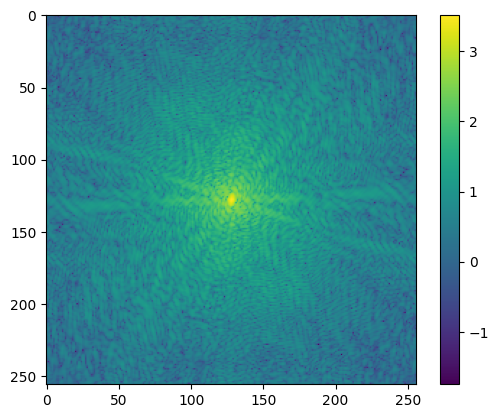

In [5]:
FT = fftn(im)
Intensity = np.abs(FT)

plt.imshow(np.log10(fftshift(Intensity))), plt.colorbar()

Agora iremos dar o primeiro passo para escrever os algoritmos de recuperação de fase, podemos escrever esses algoritmos através de projeções no espaço real e no espaço recíproco, a fim de satisfazer as nossas chamadas "restrições" em cada espaço.

Vocês conseguem me explicar a restrição de cada espaço?

In [6]:
def P_S(x, S_in):      ### P_S é a projeção do espaço real, x é o objeto no espaço real na n-ésima iteração e S_in é o suporte
    x_new = x * S_in   ### x_new é o objeto atualizado
    
    return x_new

def P_M(x, M_in): ### P_M é a projeção do espaço recíproco, x é o objeto no espaço real na n-ésima iteração e
    X = fftn(x)   ### X (maiusculo) é o objeto no espaço recíproco e M_in são as intensidades medidas no detector.
    
    X_new = M_in * np.exp(1j * np.angle(X))   ### X_new é o espaço recíproco atualizado
    
    x_new = ifftn(X_new) ### x_new é o objeto atualizado
    
    return x_new

Vamos também definir uma métrica inicial para dizer quão boa é a nossa reconstrução. Essa métrica basicamente é o erro entre intensidade obtida para a intensidade medida.

In [7]:
def RFactor_T(Model, Reconstruction):
    errorF = np.sum(np.absolute(Reconstruction-Model)) / np.sum(Reconstruction);
    
    return errorF

## Error reduction

Vamos agora estudar o algoritmo mais simples que temos, o Error Reduction (ER). Esse é o algoritmo que costumamos apresentar nas palestras e apresentações, ilustrados naquelas figuras de ciclo. 

<img src="algoritmo_exemplo.png" class="bg-primary" width="600px">

Este algoritmo se baseia em apenas satisfazer essas duas condições em cada um dos espaços por um número definido de iterações. Podemos escrevê-lo da seguinte de forma:

(<Axes: title={'center': 'Métrica de erro'}, xlabel='Iteração', ylabel='Erro'>,
 Text(0.5, 1.0, 'Métrica de erro'),
 Text(0, 0.5, 'Erro'),
 Text(0.5, 0, 'Iteração'))

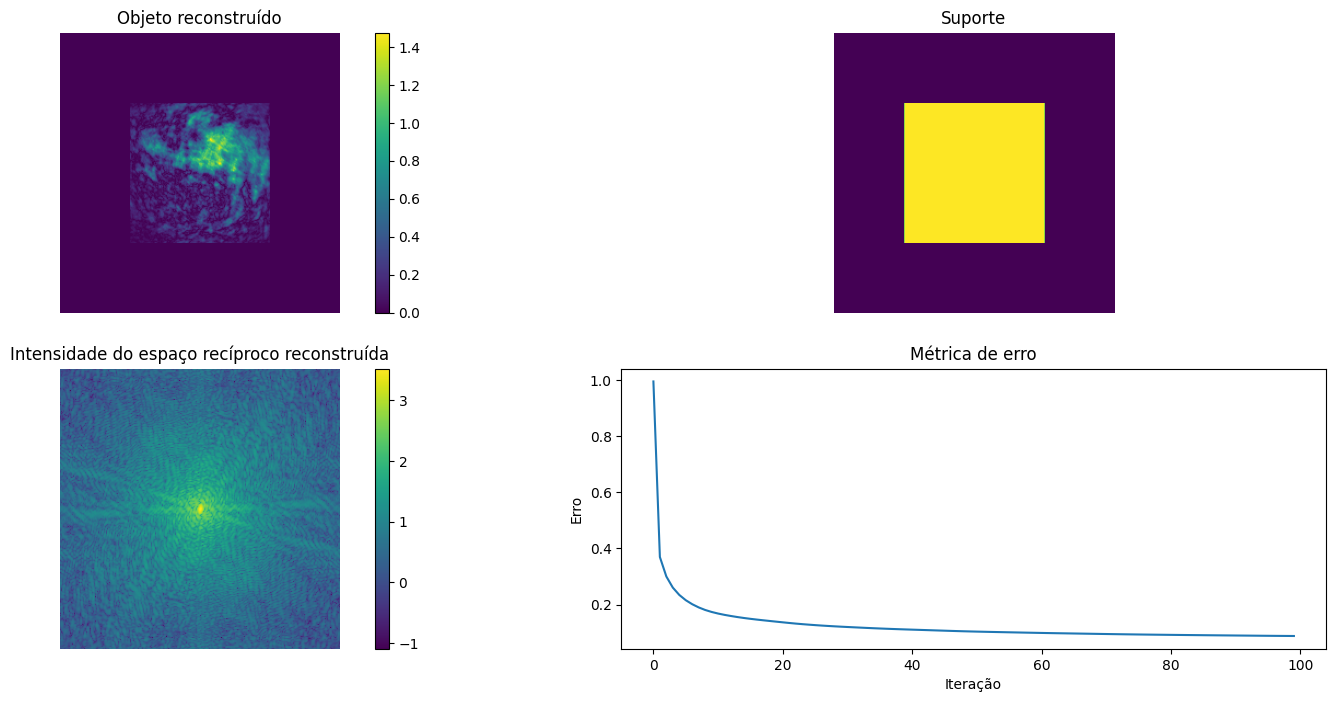

In [8]:
itmaxER = 100
RfacF = np.zeros((itmaxER, 1)).astype(np.float32);
x = np.random.rand(256,256)

supp = np.zeros(np.shape(im), dtype = bool)
supp[64:192,64:192] = 1

for it in range(itmaxER):
    
        x = P_S(P_M(x, Intensity), supp)
        x_sol = x
    
        RfacF[it] = RFactor_T(Intensity, np.abs(fftn(x_sol)))
        
int_final = np.abs(fftn(x_sol))

plt.figure(figsize = (20,8)),  plt.tight_layout()
plt.subplot(221), plt.imshow(np.abs(x_sol)), plt.axis('off'), plt.colorbar(), plt.title('Objeto reconstruído')
plt.subplot(222), plt.imshow(supp), plt.axis('off'), plt.title('Suporte')
plt.subplot(223), plt.imshow(fftshift(np.log10(int_final))), plt.axis('off'), plt.colorbar(), plt.title('Intensidade do espaço recíproco reconstruída')
plt.subplot(224), plt.plot(RfacF), plt.title('Métrica de erro'), plt.ylabel('Erro'), plt.xlabel('Iteração')

Tentem entender o conceito desse código para discutirmos depois. De inicío, brinquem apenas com a variável "itmaxER" que é o número de iterações, ou seja, o número de vezes que vamos forçar as restrições no espaço recíproco e no espaço real.

Fica mais uma pergunta pra vocês: vocês acham que o algoritmo de ER busca mínimos locais ou globais?

<img src="minimos_global_local.png" class="bg-primary" width="600px">

## Algoritmo "Hybrid input-output" (HIO)

Agora iremos definir mais um algoritmo, que nos ajuda a contornar o problema de mínimos do Error Reduction. Não irei me adentrar muito na matemática desse algoritmo em primeiro momento. O que vocês precisam saber é que esse algoritmo (HIO) tem a função de "jogar" a nossa solução pra longe de algum minímo local.

In [9]:
def HIO(x, beta, M_in, S_in):
    x_new = x + P_S(P_M(x, M_in) - x, S_in) + beta * ( P_S(P_M(x, M_in), S_in) - P_M(x, M_in) )
    
    return x_new

def R_M(x, gamma_M, M_in):
    return (1+gamma_M) * P_M(x, M_in) - gamma_M*x

def R_S(x, gamma_S, S_in):
    return (1+gamma_S) * P_S(x, S_in) - gamma_S*x

def DM(x, beta, gamma_S, gamma_M, M_in, S_in):
    x_PMRS = P_M(R_S(x, gamma_S, S_in), M_in)
    x_PSRM = P_S(R_M(x, gamma_M, M_in), S_in)
    
    x_new = x + beta*(x_PMRS - x_PSRM)
    
    return x_new, x_PSRM

(<Axes: title={'center': 'Métrica de erro'}, xlabel='Iteração', ylabel='Erro'>,
 Text(0.5, 1.0, 'Métrica de erro'),
 Text(0, 0.5, 'Erro'),
 Text(0.5, 0, 'Iteração'))

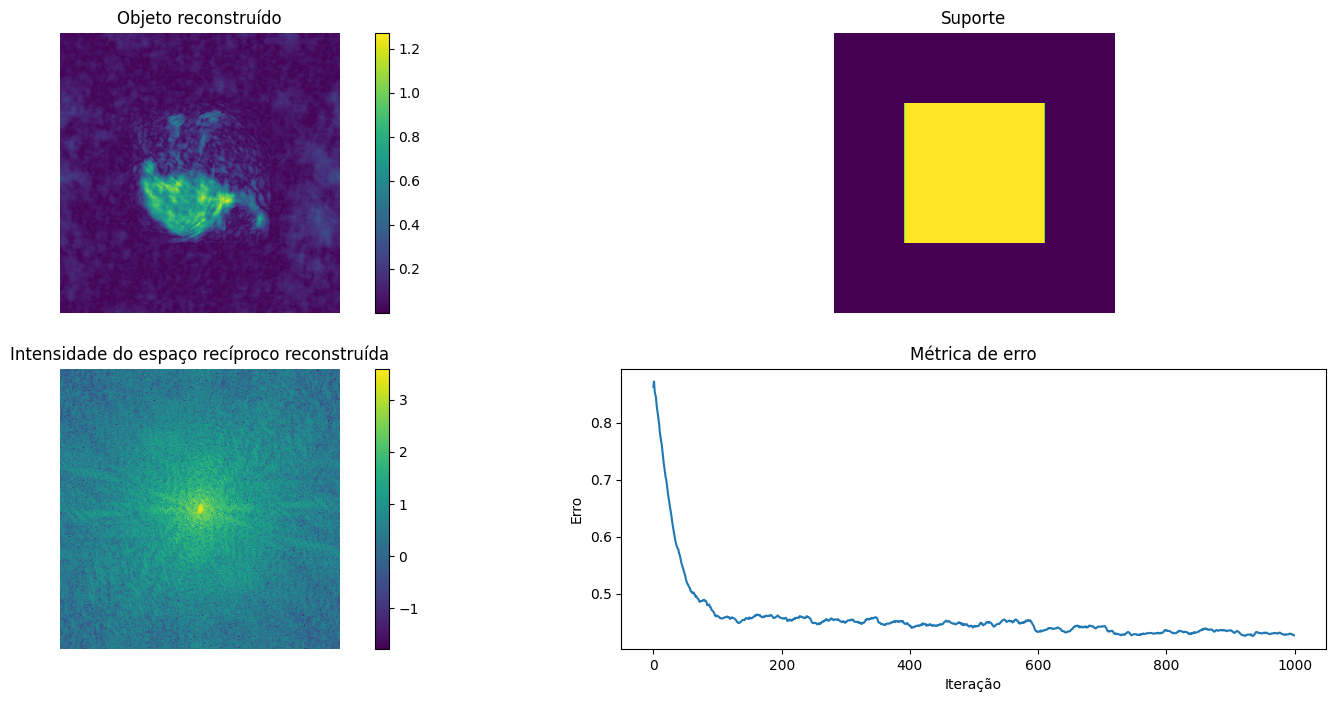

In [10]:
itmaxHIO = 1000
beta = 0.9
RfacF = np.zeros((itmaxHIO, 1)).astype(np.float32);
x = np.random.rand(256,256)

supp = np.zeros(np.shape(im), dtype = bool)
supp[64:192,64:192] = 1

for it in range(itmaxHIO):
    
        x = HIO(x, beta, Intensity, supp)
        x_sol = x
    
        RfacF[it] = RFactor_T(Intensity, np.abs(fftn(x_sol)))
        
        
int_final = np.abs(fftn(x_sol))

plt.figure(figsize = (20,8)),  plt.tight_layout()
plt.subplot(221), plt.imshow(np.abs(x_sol)), plt.axis('off'), plt.colorbar(), plt.title('Objeto reconstruído')
plt.subplot(222), plt.imshow(supp), plt.axis('off'), plt.title('Suporte')
plt.subplot(223), plt.imshow(fftshift(np.log10(int_final))), plt.axis('off'), plt.colorbar(), plt.title('Intensidade do espaço recíproco reconstruída')
plt.subplot(224), plt.plot(RfacF), plt.title('Métrica de erro'), plt.ylabel('Erro'), plt.xlabel('Iteração')

Novamente, brinquem com os argumentos "itmaxHIO" e "beta". 

## ER + HIO

O que costumamos fazer então é combinar os dois algoritmos, usando "rounds" de um numero de iterações do HIO seguidos de iterações do ER, de forma que conseguimos procurar o minimo global de forma mais eficaz, e então convergir para ele. Novamente, na célula abaixo, brinque com os valores de "rounds", "itmaxHIO", "itmaxER", "beta".

(<Axes: title={'center': 'Métrica de erro'}, xlabel='Iteração', ylabel='Erro'>,
 Text(0.5, 1.0, 'Métrica de erro'),
 Text(0, 0.5, 'Erro'),
 Text(0.5, 0, 'Iteração'))

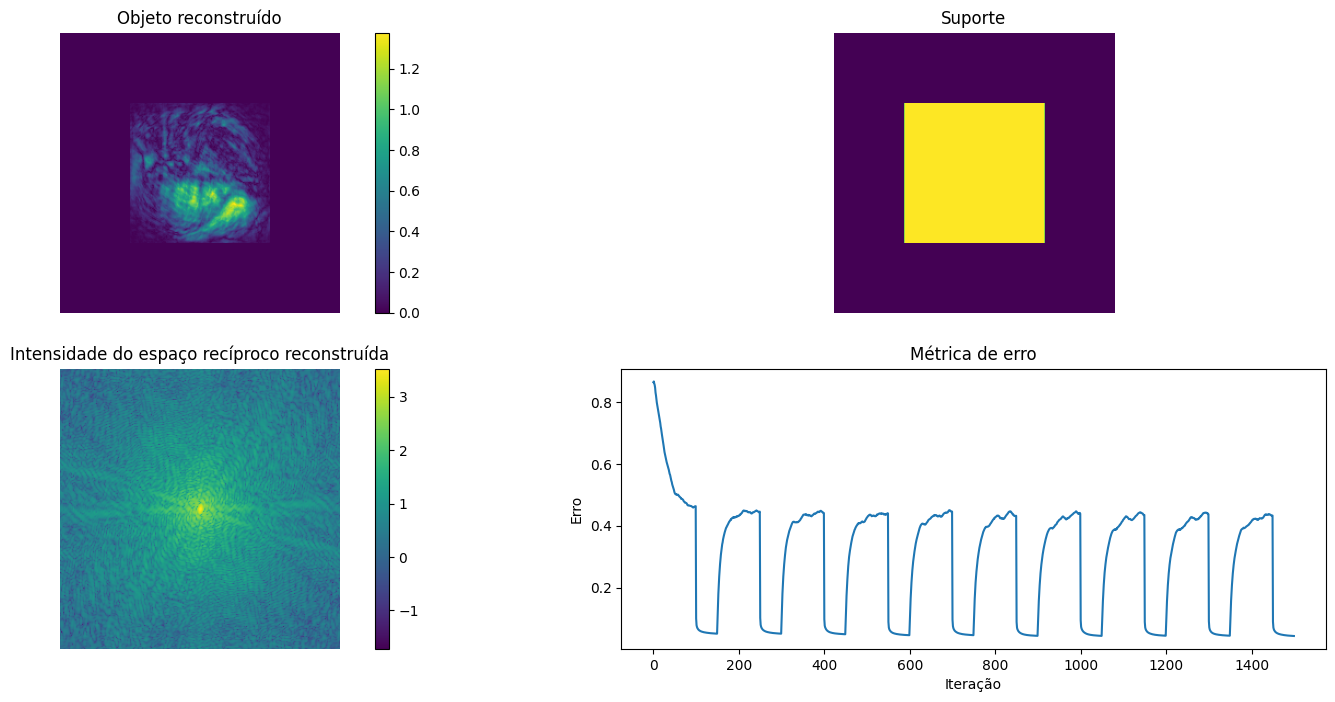

In [11]:
rounds = 10
itmaxHIO = 100
itmaxER = 50
x = np.random.rand(256,256)
beta = 0.9
RfacF = np.zeros((rounds*(itmaxHIO+itmaxER),1)).astype(np.float32);

supp = np.zeros(np.shape(im), dtype = bool)
supp[64:192,64:192] = 1

for r in range(rounds):

    for it in range(itmaxHIO):

        x = HIO(x, beta, Intensity, supp)
        
        x_sol = x
    
        RfacF[r*(itmaxHIO+itmaxER)+it] = RFactor_T(Intensity, np.abs(fftn(x)))
            
    for it in range(itmaxER):
    
        x = P_S(P_M(x, Intensity), supp)
        x_sol = x
    
        RfacF[r*(itmaxHIO+itmaxER)+itmaxHIO+it] = RFactor_T(Intensity, np.abs(fftn(x_sol)))      
    
int_final = np.abs(fftn(x_sol))
        
plt.figure(figsize = (20,8)),  plt.tight_layout()
plt.subplot(221), plt.imshow(np.abs(x_sol)), plt.axis('off'), plt.colorbar(), plt.title('Objeto reconstruído')
plt.subplot(222), plt.imshow(supp), plt.axis('off'), plt.title('Suporte')
plt.subplot(223), plt.imshow(fftshift(np.log10(int_final))), plt.axis('off'), plt.colorbar(), plt.title('Intensidade do espaço recíproco reconstruída')
plt.subplot(224), plt.plot(RfacF), plt.title('Métrica de erro'), plt.ylabel('Erro'), plt.xlabel('Iteração')

## ER + HIO + Shrinkwrap

Notem que até agora nenhum dos métodos funcionou muito bem, de forma que a imagem reconstruída lembra muito pouco a imagem da EMA. Contudo, se nossa informação no espaço real for mais restritiva, isto é, soubermos exatamente o formato da amostra, por exemplo, o algoritmo converge quase que imediatamente. Supondo que sabemos então exatamente o suporte, a reconstrução pro algoritmo de ER fica:

(<Axes: title={'center': 'Métrica de erro'}, xlabel='Iteração', ylabel='Erro'>,
 Text(0.5, 1.0, 'Métrica de erro'),
 Text(0, 0.5, 'Erro'),
 Text(0.5, 0, 'Iteração'))

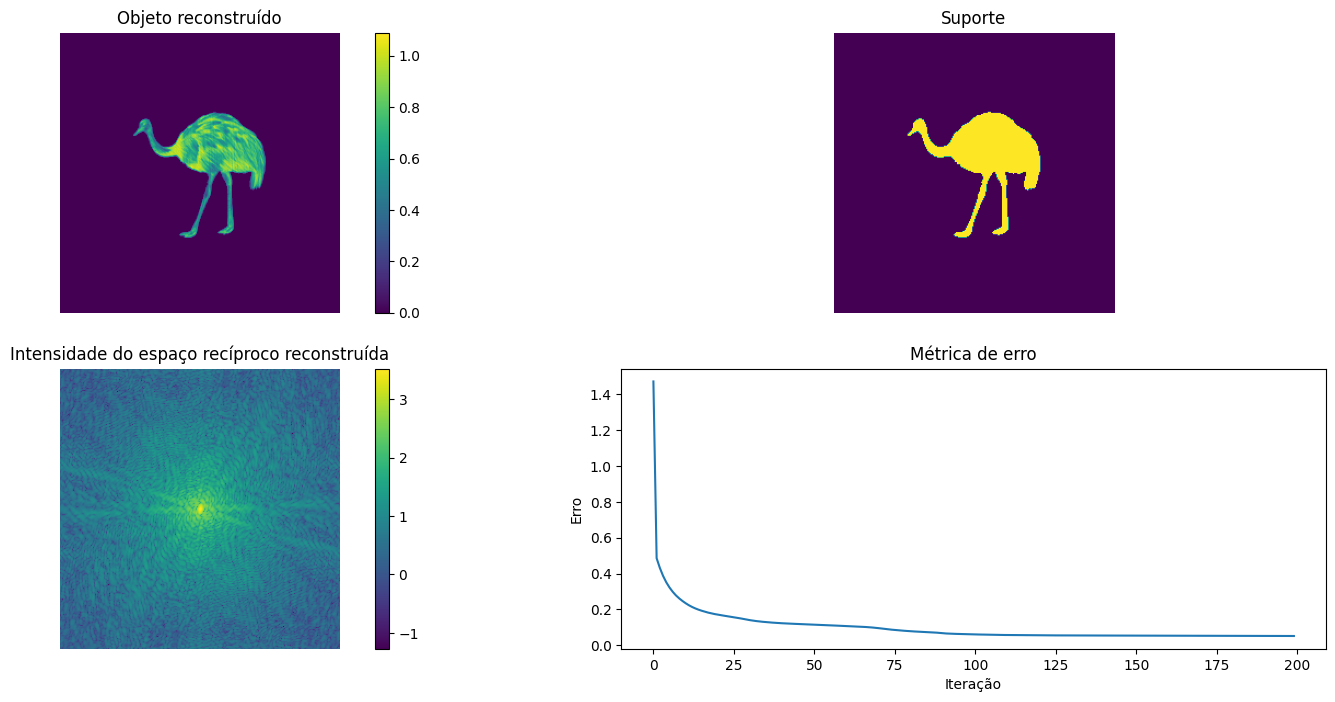

In [12]:
itmaxER = 200
RfacF = np.zeros((itmaxER, 1)).astype(np.float32);
x = np.random.rand(256,256)

supp = im > 0.1

for it in range(itmaxER):
    
        x = P_S(P_M(x, Intensity), supp)
        x_sol = x
    
        RfacF[it] = RFactor_T(Intensity, np.abs(fftn(x_sol)))
        
int_final = np.abs(fftn(x_sol))

plt.figure(figsize = (20,8)),  plt.tight_layout()
plt.subplot(221), plt.imshow(np.abs(x_sol)), plt.axis('off'), plt.colorbar(), plt.title('Objeto reconstruído')
plt.subplot(222), plt.imshow(supp), plt.axis('off'), plt.title('Suporte')
plt.subplot(223), plt.imshow(fftshift(np.log10(int_final))), plt.axis('off'), plt.colorbar(), plt.title('Intensidade do espaço recíproco reconstruída')
plt.subplot(224), plt.plot(RfacF), plt.title('Métrica de erro'), plt.ylabel('Erro'), plt.xlabel('Iteração')

Como no experimento não sabemos exatamente o formato do objeto, e na verdade, o formato é exatamente o que queremos descobrir, adicionaremos mais um artifício para ajudar na convergência do algoritmo, a chamada técnica de "Shrinkwrap", em que a cada round de iterações dos algoritmos de HIO e ER, vamos reduzir o nosso suporte. Para isso vamos ter de "borrar" nossa imagem. Iremos fazer isso através de uma função Gaussiana.

In [13]:
def convolution_filter(x, kernel):
    return ifftn(fftn(x) * kernel)

def Gaussian2D(Nx, Ny, sx, sy):
    x = np.linspace(-Nx/2, Nx/2, Nx)
    y = np.linspace(-Ny/2, Ny/2, Ny)
    x, y = np.meshgrid(x,y)
    
    z = np.exp(-(x/sx)**2 - (y/sy)**2)
    
    return z

Usando a função "Gaussian2D" aplicada na função "convolution_filter", podemos filtrar qualquer imagem, por exemplo, a imagem da EMA:

(<Axes: title={'center': 'EMA borrada'}>,
 (-0.5, 255.5, 255.5, -0.5),
 Text(0.5, 1.0, 'EMA borrada'))

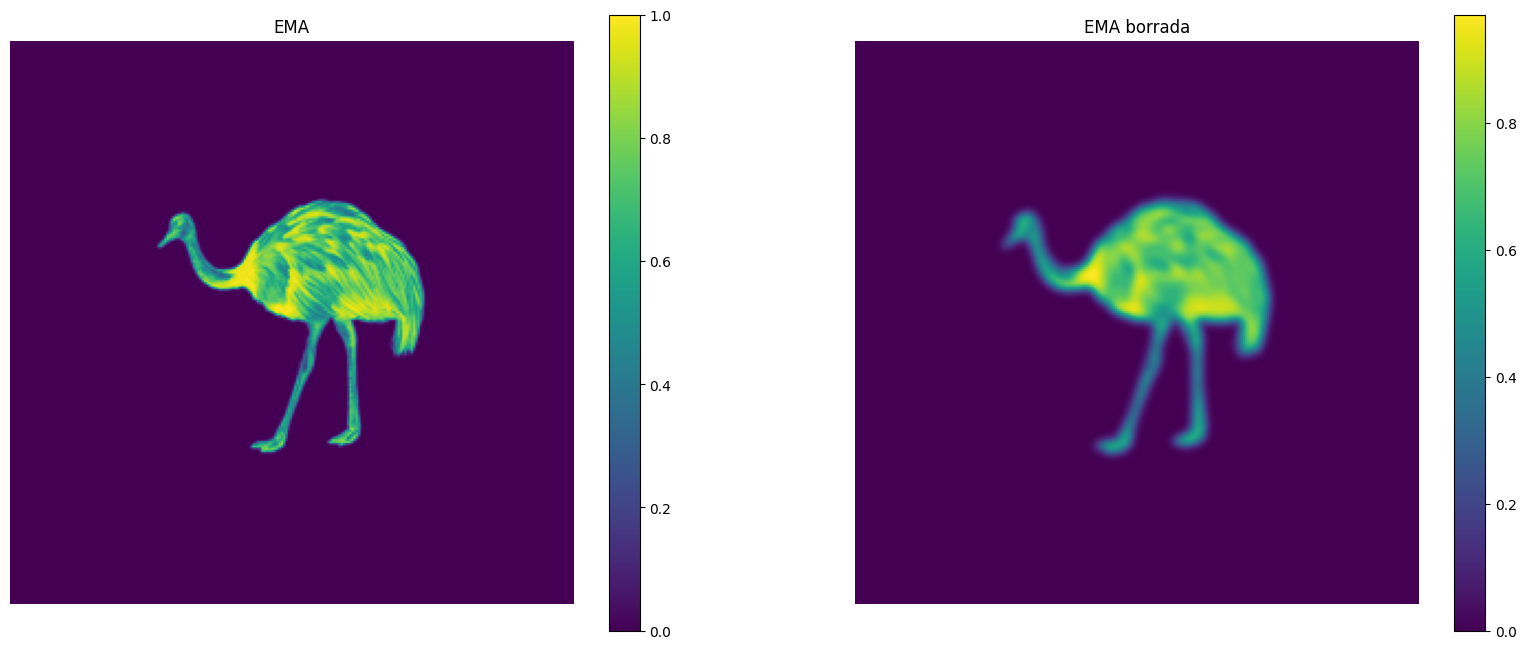

In [14]:
C_lp = Gaussian2D(256, 256, 30, 30)
C_lp = ifftshift(C_lp)

EMA_borrada = convolution_filter(im, kernel = C_lp)

plt.figure(figsize = (20,8)),  plt.tight_layout()
plt.subplot(121), plt.imshow(im), plt.axis('off'), plt.colorbar(), plt.title('EMA')
plt.subplot(122), plt.imshow(np.abs(EMA_borrada)), plt.axis('off'), plt.colorbar(), plt.title('EMA borrada')

Note que podemos fazer isso para diferentes Gaussianas, de forma que quanto menores os valores "sx" e "sy", mais borrada será a imagem.

O objetivo então na verdade é borrar a imagem enquanto está rodando o algoritmo de reconstrução, por exemplo, após cada round de iterações. Dessa forma, aplicaremos um limite inferior para redefinir o conjunto de pontos que definem o nosso suporte.

E isso que acontece por exemplo no gif abaixo:

![SegmentLocal](HIO+ER+Shrinkwrap.gif "segment")

Logo abaixo, temos então o algoritmo de HIO+ER+Shrinkwrap. Novamente, na célula abaixo, brinque com os valores de "rounds", "itmaxHIO", "itmaxER", "beta" e "threshold". 

(<Axes: title={'center': 'Métrica de erro'}, xlabel='Iteração', ylabel='Erro'>,
 Text(0.5, 1.0, 'Métrica de erro'),
 Text(0, 0.5, 'Erro'),
 Text(0.5, 0, 'Iteração'))

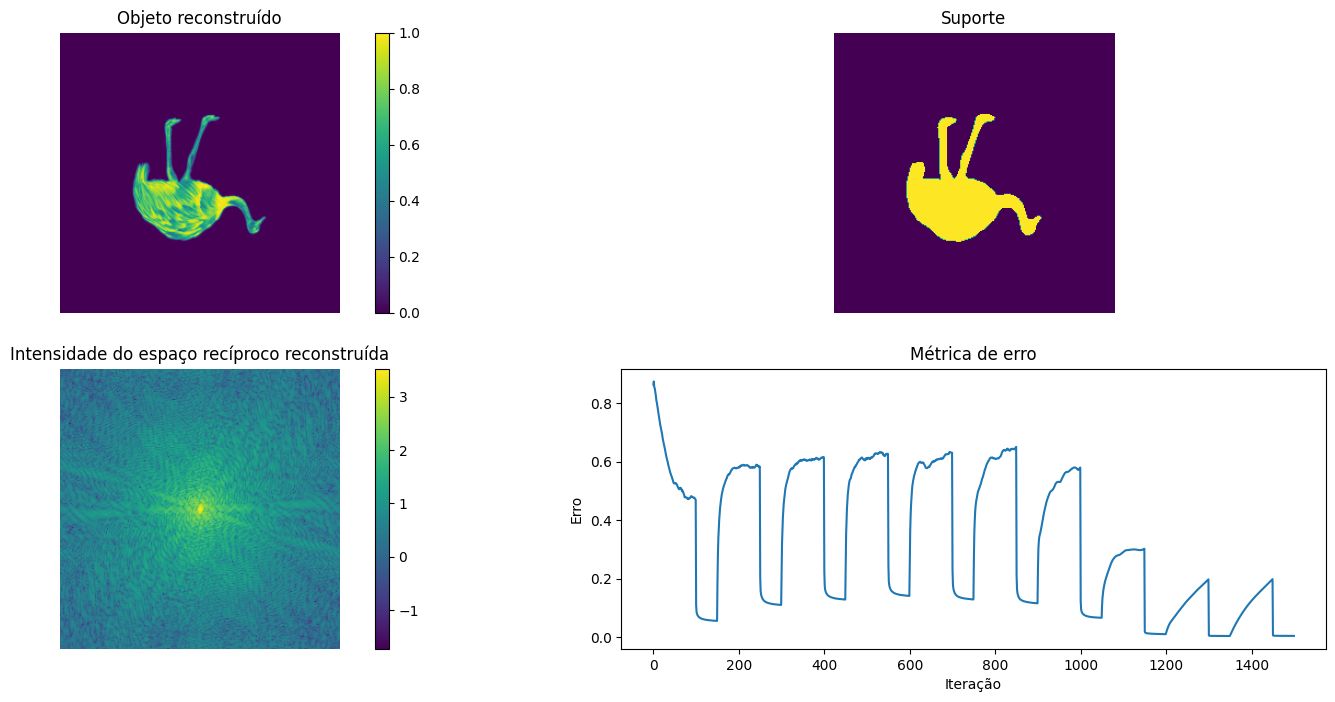

In [15]:
rounds = 10
itmaxHIO = 100
itmaxER = 50
x = np.random.rand(256,256)
beta = 0.9
gamma_M = -1/beta
gamma_S = 1/beta
RfacF = np.zeros((rounds*(itmaxHIO+itmaxER),1)).astype(np.float32);

supp = np.zeros(np.shape(im), dtype = bool)
supp[64:192,64:192] = 1

C_lp = Gaussian2D(256, 256, 60, 60)
C_lp = ifftshift(C_lp)

for r in range(rounds):

    for it in range(itmaxHIO):

        #x, x_sol = DM(x, beta, gamma_S, gamma_M, Intensity, supp)
        x = HIO(x, beta, Intensity, supp)
        
        x_sol = x
    
        RfacF[r*(itmaxHIO+itmaxER)+it] = RFactor_T(Intensity, np.abs(fftn(x)))
            
    for it in range(itmaxER):
    
        x = P_S(P_M(x, Intensity), supp)
        x_sol = x
    
        RfacF[r*(itmaxHIO+itmaxER)+itmaxHIO+it] = RFactor_T(Intensity, np.abs(fftn(x_sol)))

        
    ### NESSA PARTE QUE ATUALIZAMOS O SUPORTE
    
    x_mod = convolution_filter(x_sol, kernel = C_lp)
    x_mod = np.abs(x_mod)
    x_mod /= np.amax(x_mod)
    threshold = 0.05
    supp = x_mod > threshold   
    
    
int_final = np.abs(fftn(x_sol))
        
plt.figure(figsize = (20,8)),  plt.tight_layout()
plt.subplot(221), plt.imshow(np.abs(x_sol)), plt.axis('off'), plt.colorbar(), plt.title('Objeto reconstruído')
plt.subplot(222), plt.imshow(supp), plt.axis('off'), plt.title('Suporte')
plt.subplot(223), plt.imshow(fftshift(np.log10(int_final))), plt.axis('off'), plt.colorbar(), plt.title('Intensidade do espaço recíproco reconstruída')
plt.subplot(224), plt.plot(RfacF), plt.title('Métrica de erro'), plt.ylabel('Erro'), plt.xlabel('Iteração')